<a href="https://colab.research.google.com/github/kessingtonosazee/GCP_Project_1/blob/master/aml_2324_w7_webinar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages and Set Up Environment

In [ ]:
!pip install --upgrade scikit-learn==1.4.0 -q
!pip install --upgrade category_encoders -q
!pip install -q shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.5 MB/s eta 0:00:00


In [ ]:
import sklearn
sklearn.set_config(transform_output="pandas")

%config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(
    { "figure.figsize": (6, 4) }, style='ticks', color_codes=True, font_scale=0.8
)

from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from sklearn.metrics import mean_absolute_error

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, RFECV, SequentialFeatureSelector


import shap
shap.initjs()

## Case Study: Breast Cancer Dataset

* Popular classification dataset for classifying tumor into begign/malign based on shape/size/texture of tumors.

* https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
X, y = load_breast_cancer(as_frame=True, return_X_y=True)

In [ ]:
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## EDA: Look at Good Predictors and Possible Multicollinearity

### Predictors, Visually

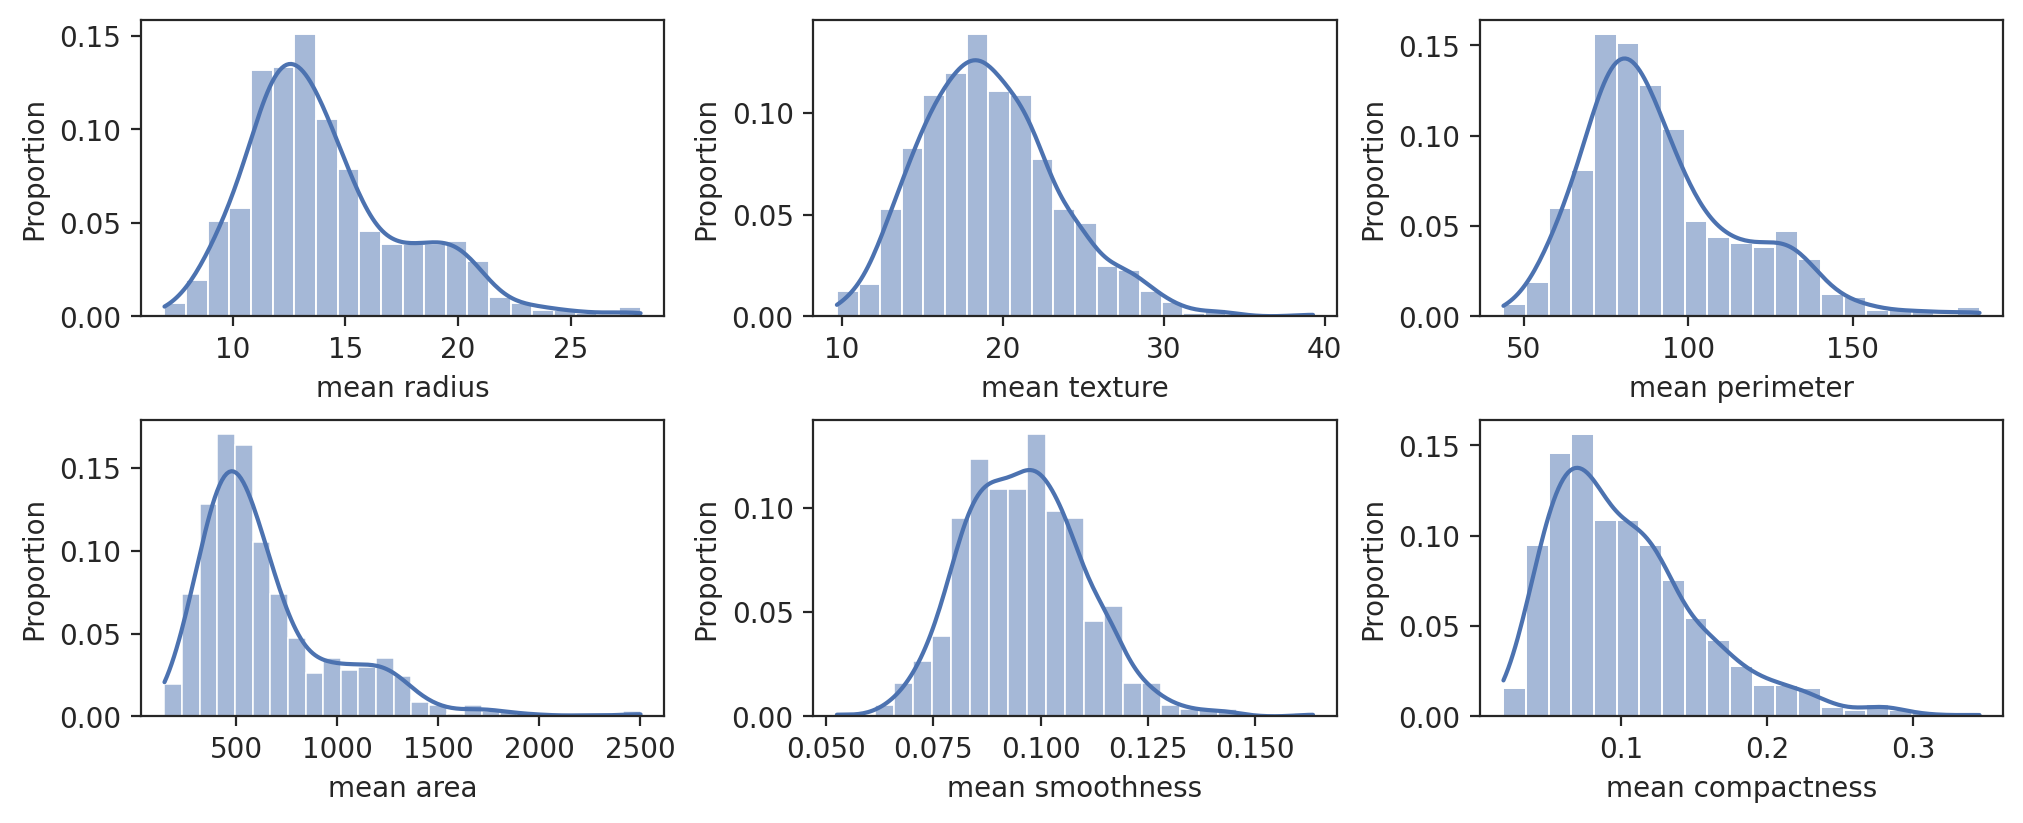

In [ ]:
cols = X.columns
n_cols = 3
n_rows = 2
fig, axs = plt.subplots(
    n_rows, n_cols, figsize=(10, n_rows*2), constrained_layout=True
)
# one of my favourite idioms for iterating over pairs of aligned vectors...
for col, ax in zip(cols[:6], axs.ravel()):
    sns.histplot(x=X[col], stat='proportion', common_norm=False, kde=True, ax=ax);

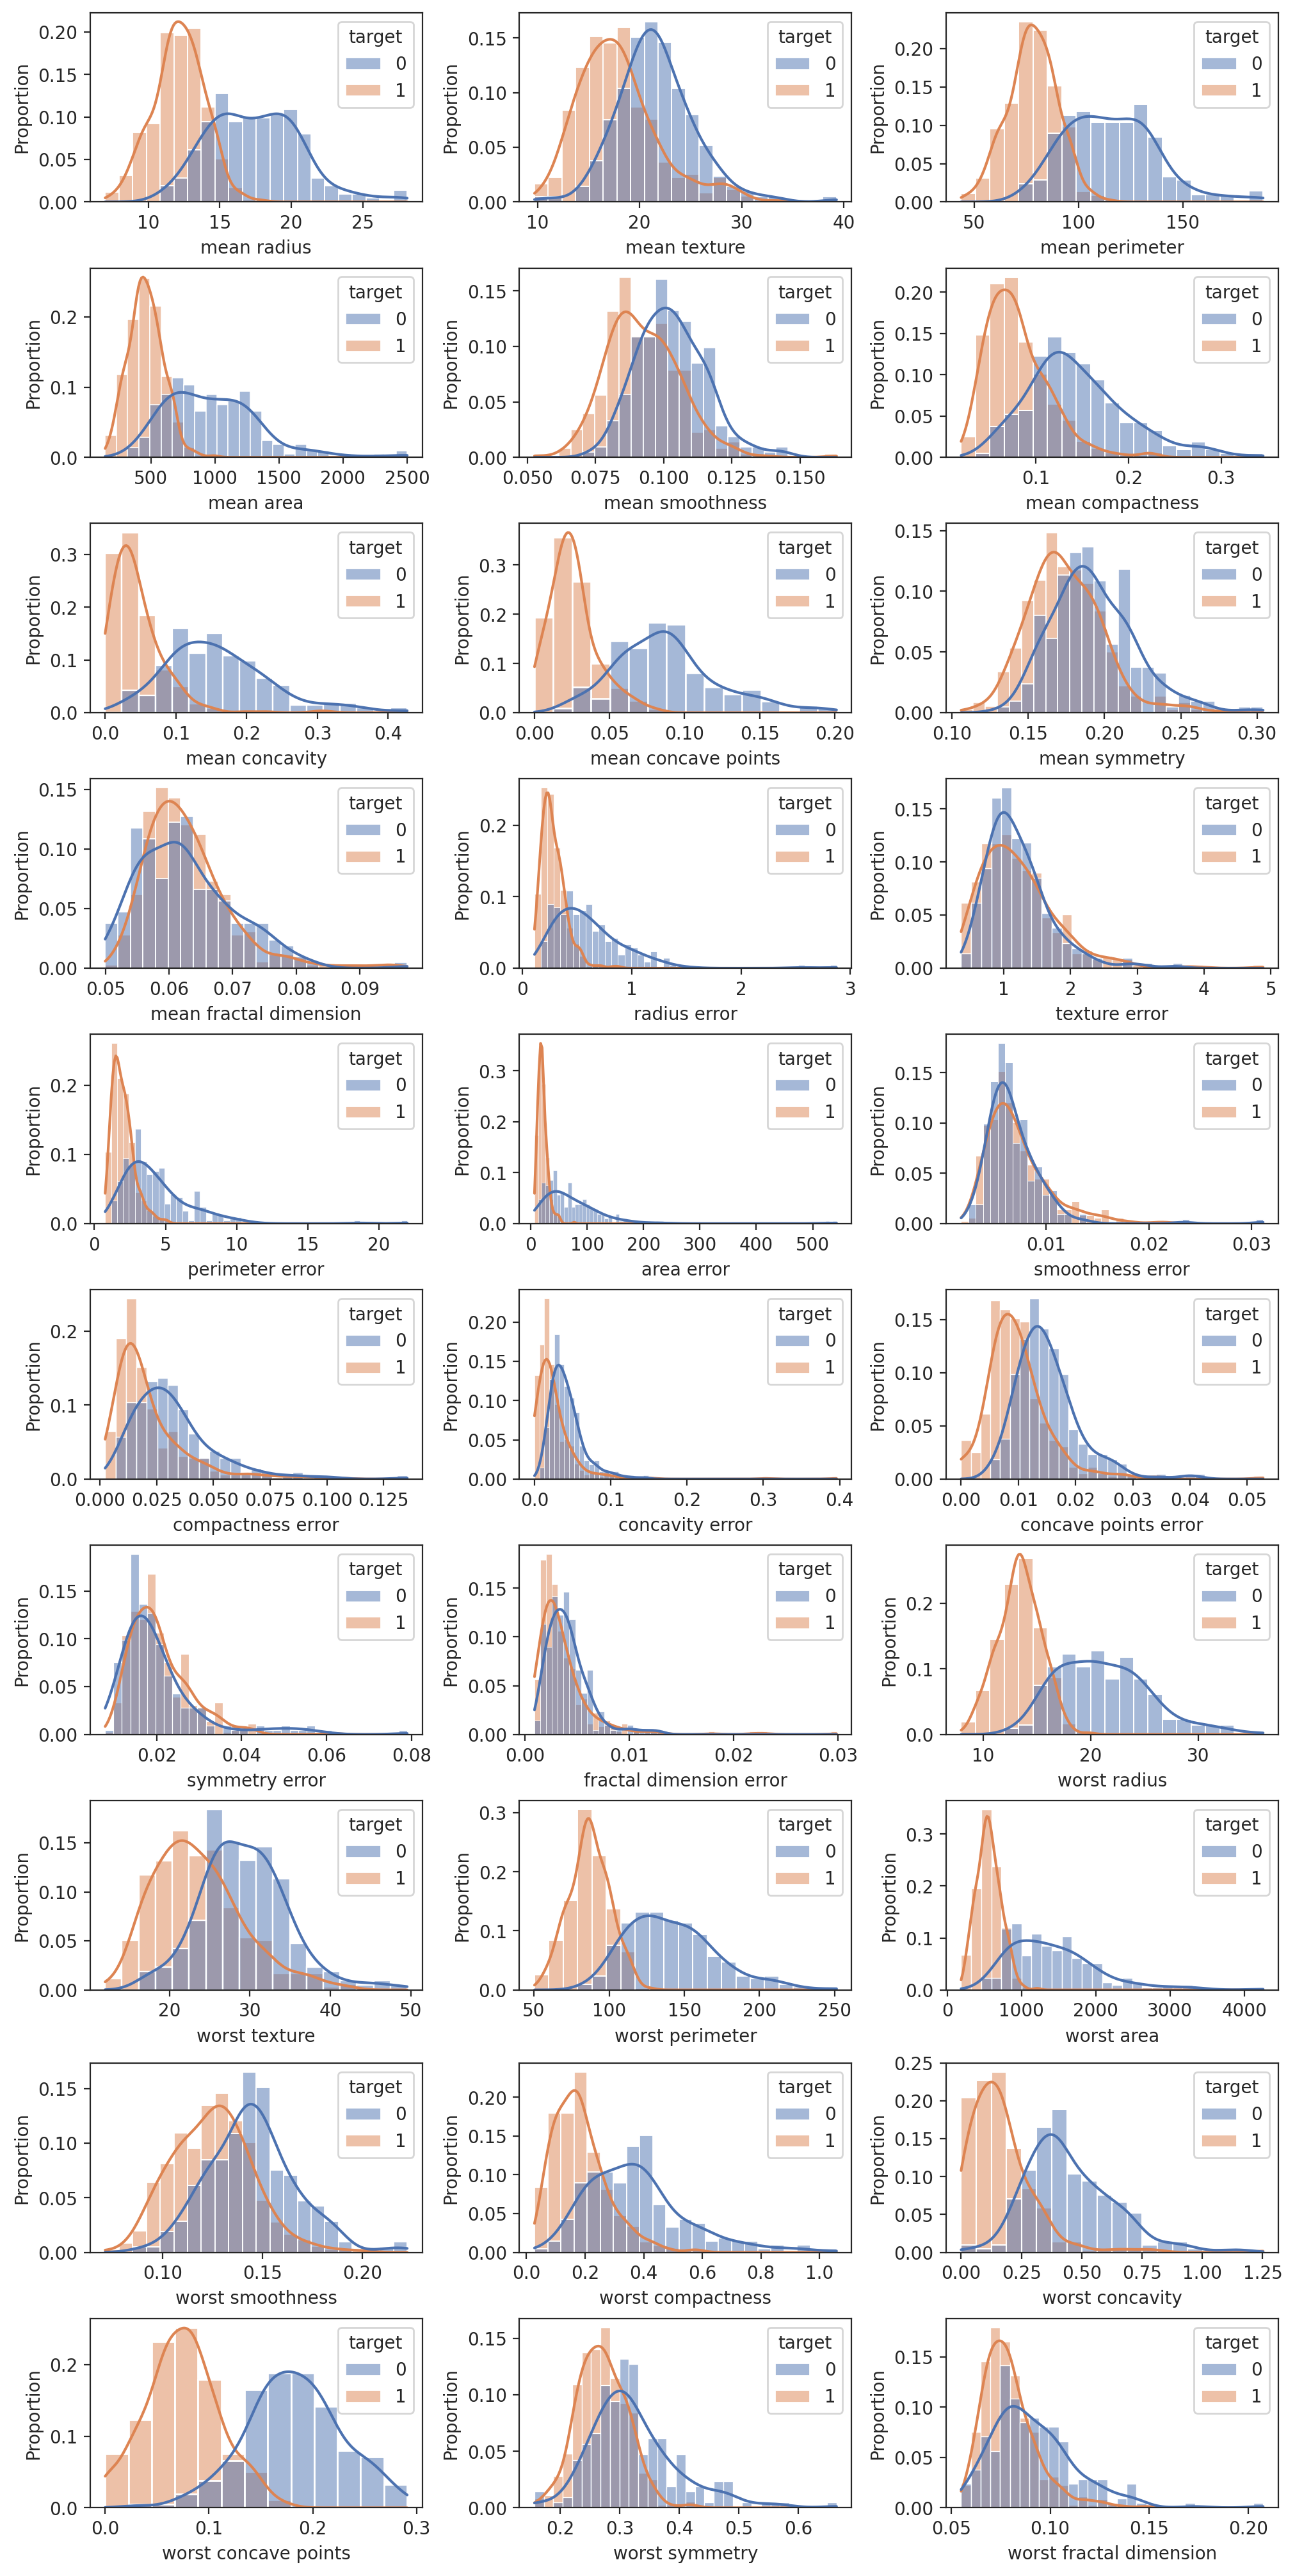

In [ ]:
cols = X.columns
n_cols = 3
n_rows = 10
fig, axs = plt.subplots(
    n_rows, n_cols, figsize=(10, n_rows*2), constrained_layout=True
)
# one of my favourite idioms for iterating over pairs of aligned vectors...
for col, ax in zip(cols, axs.ravel()):
    sns.histplot(x=X[col], stat='proportion', common_norm=False, hue=y, kde=True, ax=ax);

### Collinearity

In [ ]:
size_related = X.filter(regex='radius|area')
size_related = size_related.assign(target=y)

In [ ]:
size_related.head(1)

,mean radius,mean area,radius error,area error,worst radius,worst area,target
0,17.99,1001.0,1.095,153.4,25.38,2019.0,0


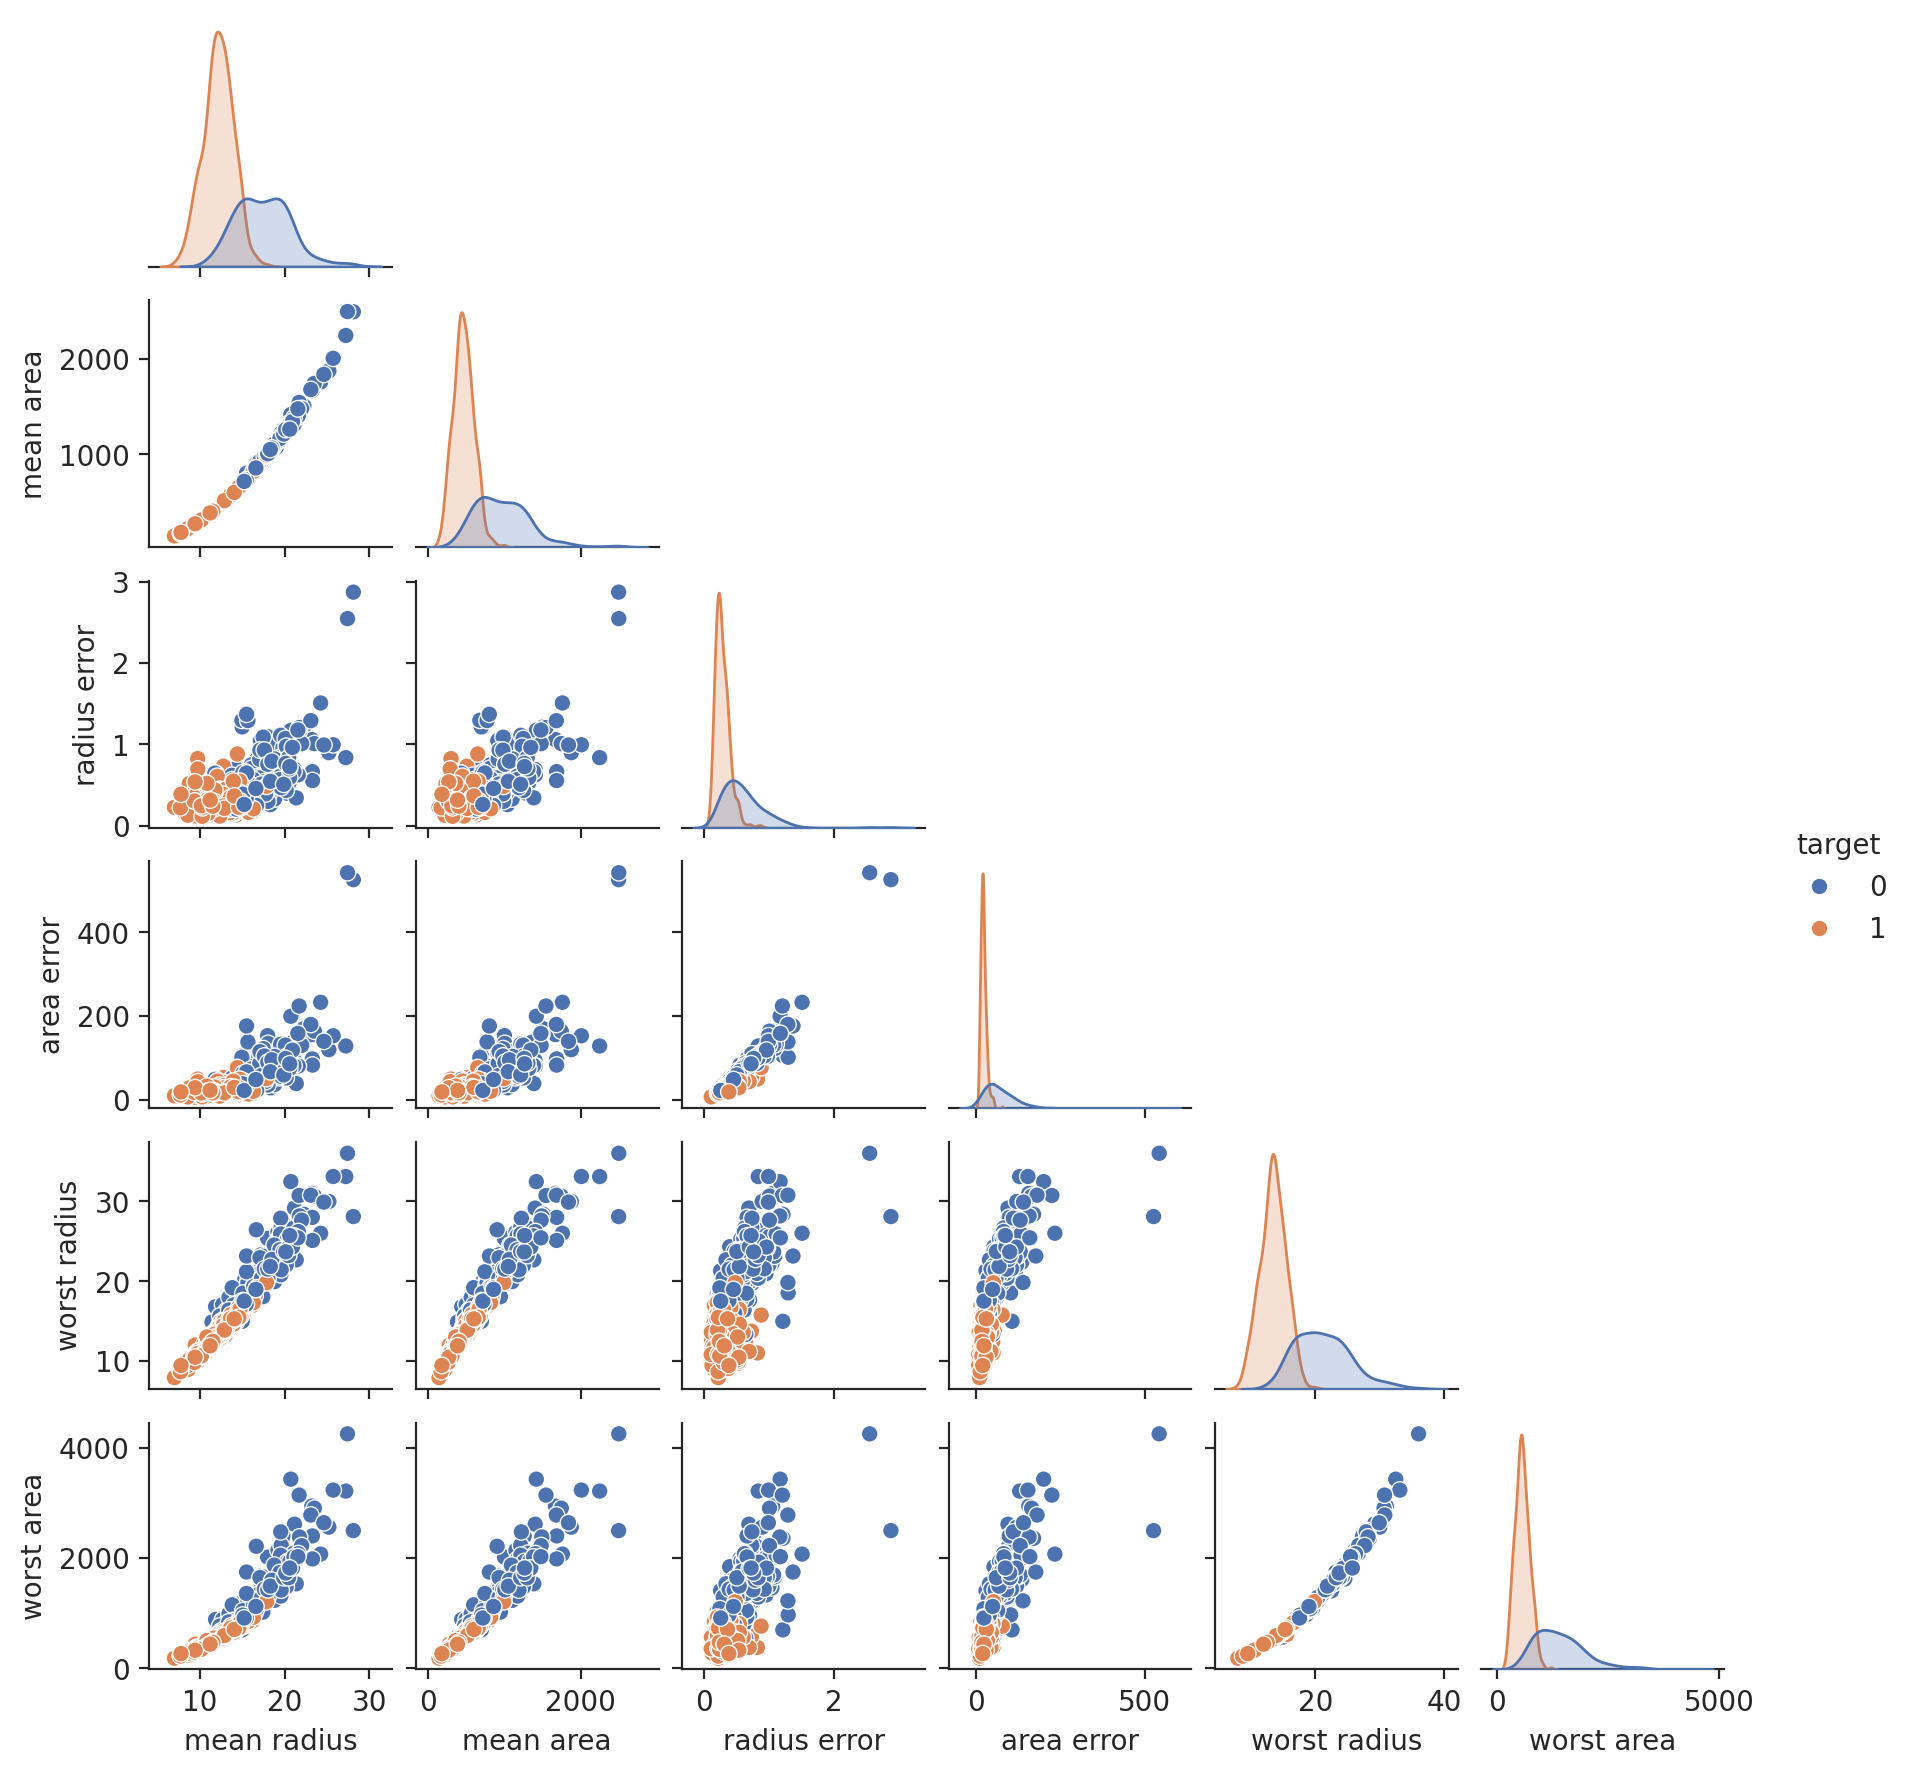

In [ ]:
sns.pairplot(
    data=size_related, hue='target', corner=True, height=1.5
);

### Preparing Data for ML

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

### What Happens with Select $k$ Best?

In [ ]:
regr_bestk = Pipeline(
    steps=[
        ("feat_sel", SelectKBest(mutual_info_classif, k=10)),
        ("regr", RandomForestRegressor())
    ]
)

In [ ]:
regr_bestk.fit(X_train, y_train)

Pipeline(steps=[('feat_sel',
                 SelectKBest(score_func=<function mutual_info_classif at 0x7bc5e7cadcf0>)),
                ('regr', RandomForestRegressor())])

In [ ]:
np.sort(regr_bestk['feat_sel'].get_feature_names_out())

array(['area error', 'mean area', 'mean concave points', 'mean concavity',
       'mean perimeter', 'mean radius', 'worst area',
       'worst concave points', 'worst perimeter', 'worst radius'],
      dtype=object)

### RFE

In [ ]:
regr_rfe = Pipeline(
    steps=[
        ("feat_sel", RFECV(LinearRegression(), step=1, cv=5)),
        ("regr", RandomForestRegressor())
    ]
)

In [ ]:
regr_rfe.fit(X_train, y_train)

Pipeline(steps=[('feat_sel', RFECV(cv=5, estimator=LinearRegression())),
                ('regr', RandomForestRegressor())])

In [ ]:
rfe_selector = regr_rfe['feat_sel']

In [ ]:
np.sort(rfe_selector.get_feature_names_out())

array(['compactness error', 'concave points error', 'concavity error',
       'fractal dimension error', 'mean compactness',
       'mean concave points', 'mean concavity', 'mean fractal dimension',
       'mean perimeter', 'mean radius', 'mean smoothness',
       'mean symmetry', 'mean texture', 'perimeter error', 'radius error',
       'smoothness error', 'symmetry error', 'texture error',
       'worst area', 'worst compactness', 'worst concave points',
       'worst concavity', 'worst fractal dimension', 'worst perimeter',
       'worst radius', 'worst smoothness', 'worst symmetry',
       'worst texture'], dtype=object)

In [ ]:
len(np.sort(rfe_selector.get_feature_names_out()))

28

In [ ]:
# should match the number of features
n_scores = len(rfe_selector.cv_results_["mean_test_score"])
n_scores

30

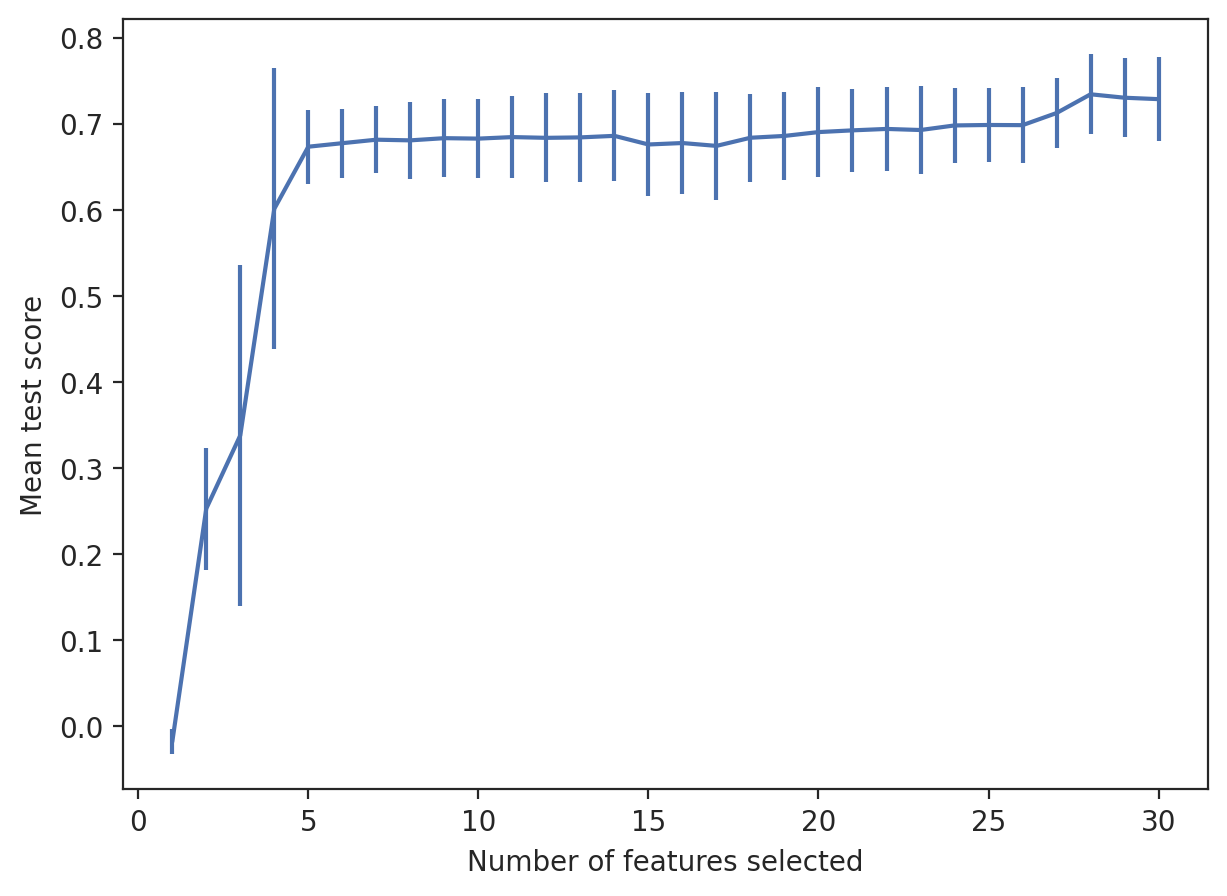

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
ax.errorbar(
    range(1, n_scores+1),
    rfe_selector.cv_results_["mean_test_score"],
    yerr=rfe_selector.cv_results_["std_test_score"],
)
ax.set_xlabel("Number of features selected")
ax.set_ylabel("Mean test score");

In [ ]:
# from 30 features up to a single one
np.flip(rfe_selector.cv_results_["mean_test_score"])

array([ 0.72880493,  0.7304431 ,  0.73445332,  0.71267999,  0.69859026,
        0.69878609,  0.69826002,  0.69293236,  0.69419141,  0.69253943,
        0.69052949,  0.68606208,  0.68395054,  0.67447912,  0.67780974,
        0.67612603,  0.68615024,  0.68436692,  0.68384446,  0.68472598,
        0.68293654,  0.68346944,  0.68091824,  0.68168575,  0.67763795,
        0.67353804,  0.60138378,  0.338078  ,  0.25294133, -0.0180851 ])

### Sequential Feature Selector (SFS)

In [ ]:
regr_sfs = Pipeline(
    steps=[
        ("feat_sel", SequentialFeatureSelector(
            LinearRegression(), n_features_to_select='auto',
            direction="forward", tol=0.01)),
        ("regr", RandomForestRegressor())
    ]
)

In [ ]:
regr_sfs.fit(X_train, y_train)

Pipeline(steps=[('feat_sel',
                 SequentialFeatureSelector(estimator=LinearRegression(),
                                           tol=0.01)),
                ('regr', RandomForestRegressor())])

In [ ]:
np.sort(regr_sfs['feat_sel'].get_feature_names_out())

array(['radius error', 'worst area', 'worst concave points',
       'worst radius', 'worst smoothness', 'worst texture'], dtype=object)

In [ ]:
regr_sfs.score(X_train, y_train)

0.9781115047021943

In [ ]:
regr_sfs.score(X_test, y_test)

0.9171481740234995

In [ ]:
regr_rfe.score(X_train, y_train)

0.9775504806687565

In [ ]:
regr_rfe.score(X_test, y_test)

0.8749692600825659